In [6]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants
import np_lib

from typing import Tuple, List

In [7]:
# Network dimensions
N_x, N_y, N_z = 2, 2, 2

# Number of particles
N_particles = N_x * N_y * N_z
    
# Nanoparticle Resistance
R               = 25e-12

# Input Electrode Positions
input_pos = [[0,0,0]]

# Output Electrode Positions
output_pos = [[N_x - 1, N_y - 1, N_z - 1]]

# Control Electrode Positions
control_pos = []

# Temperature [K]
T = 0.28

# Further Constants

electron_charge = 0.1602176634  # [aC]             a = atto
kb = 1.380649e-05               # Boltzmannkonstante [aJ/K]
tunnel_resistance = 2.5e-11     # Tunnelwiderstand [1/a Ohm]



In [8]:
capacitance_values, elec = np_lib.build_network(N_x, N_y, N_z, input_pos, output_pos, control_pos)
C = elec.capacitance_matrix     # Capacitance in [aF]
inv_C = np.linalg.inv(C)

In [9]:
def get_index(index_x : int, index_y : int, index_z : int) -> int:
    """
    Transforms nanoparitcle-3D-coordinates to linear indices
    """
    return index_x + N_x * index_y + N_x * N_y * index_z

In [10]:
def get_voltage_config(input_voltages : List[float], output_voltages : List[float], control_voltages : List[float], gate_voltage : float) -> dict:
    """
    Bundles all voltages aplied to the network
    input_voltages      :   list of voltages for each input electrode
    output_voltages     :   list of voltages for each output electrode
    control_voltages    :   list of voltages for each control electrode
    """

    assert len(input_voltages) == len(input_pos), "Wrong number of input voltages"
    assert len(output_voltages) == len(output_pos), "Wrong number of output voltages"
    assert len(control_voltages) == len(control_pos), "Wrong number of control voltages"

    return {
        'input_voltages'   : input_voltages,
        'output_voltages'  : output_voltages,
        'control_voltages' : control_voltages,
        'gate_voltage'     : gate_voltage
    }

In [11]:
def calc_induced_charges(voltage_config : dict) -> List[float]:
    """
    For given voltage configuration, this calculates what needs to be added to the elementary system-charges
    to calculate the charge vector. The in/out/control charges will be added only to particles whose positions are specified.
    The gate voltage will be apllied to all particles concerning the self-capacitance.

    This is just an effect created by applied voltages
    """

    dq = np.zeros(shape = N_particles)

    c_electrode = capacitance_values['lead']    #Kapazität zu den Elektroden
    c_gate = capacitance_values["self"]         #Kapazität zum Gate

    ## input electrodes
    for i, (x,y,z) in enumerate(input_pos):
        list_index = get_index(x,y,z)
        dq[list_index] += voltage_config['input_voltages'][i] * c_electrode

    ## output electrodes
    for i, (x,y,z) in enumerate(output_pos):
        list_index = get_index(x,y,z)
        dq[list_index] += voltage_config['output_voltages'][i] * c_electrode

    ## control electrodes
    for i, (x,y,z) in enumerate(control_pos):
        list_index = get_index(x,y,z)
        dq[list_index] += voltage_config['control_voltages'][i] * c_electrode

    dq += c_gate * voltage_config['gate_voltage']

    return dq

In [7]:
def calc_free_energy(charge_vector : List[float]) -> float:
    """
    Calculates the total free energy
    charge_vector   :   represents the effective charges on each island
    """
    assert charge_vector.shape == (N_particles,), "Wrong number of particles"

    F = 0.5 * charge_vector.T @ inv_C @ charge_vector

    return F

In [9]:
def apply_tunnel_event(charge_vector : List[float], index_from : int, index_to : int) -> List[float]:
    """
    Copies the charge vector and changes it according to tunnel event
    charge_vector   :   vector describing the effective charges on each island
    index_from      :   island-index from where electron tunnels
    index_to        :   island to which electron tunnels
    """
    res = np.array(charge_vector, copy = True)
    res[index_from] -= electron_charge
    res[index_to] += electron_charge

    return res

In [21]:
def calc_tunnel_rate(deltaF):
    return np.where(deltaF == 0, kb*T/electron_charge**2/tunnel_resistance, -deltaF/electron_charge**2/tunnel_resistance/(1 - np.exp(deltaF/kb/T)))

/tmp/ipykernel_2479/1325591797.py:2: RuntimeWarning: overflow encountered in exp
  return np.where(deltaF == 0, kb*T/electron_charge**2/tunnel_resistance, -deltaF/electron_charge**2/tunnel_resistance/(1 - np.exp(deltaF/kb/T)))
/tmp/ipykernel_2479/1325591797.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(deltaF == 0, kb*T/electron_charge**2/tunnel_resistance, -deltaF/electron_charge**2/tunnel_resistance/(1 - np.exp(deltaF/kb/T)))


Text(0, 0.5, 'Gama [1/s]')

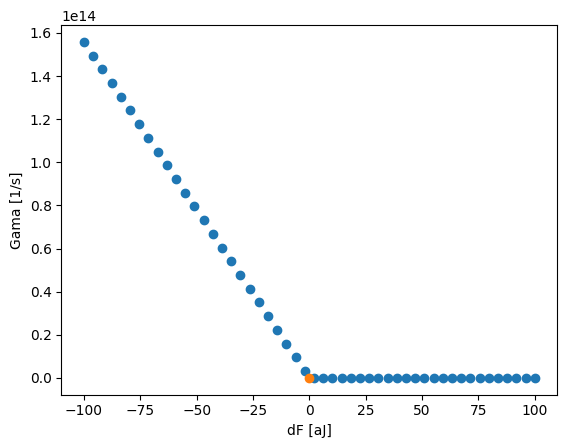

In [48]:
xs = np.linspace(-100,100)
ys = calc_rate(xs)
plt.scatter(xs, ys)
plt.scatter(0,calc_rate(0))
plt.xlabel("dF [aJ]")
plt.ylabel("Gama [1/s]")

In [20]:
n = np.array([1,2,3,4,1,2,3,4])

voltage_config = get_voltage_config(input_voltages=[1],output_voltages=[-1],control_voltages=[],gate_voltage=0)
dq = calc_induced_charges(voltage_config)

q = electron_charge * n + dq

In [ ]:
calc_tunnel_rate_island()